<a href="https://colab.research.google.com/github/giriragav/UChicago---QCSD/blob/main/Module%202/lab5/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 5</div>

In the videos, you saw the steps to compile and optimize a quantum algorithm.  For this lab, you will again start with a small circuit, the Cuccaro adder.  This by itself is not a quantum algorithm but can be used as a component in algorithms.  The Cuccaro adder takes as input two quantum registers, a carry-in qubit, and a carry-out qubit and as output overwrites one of the registers and the carry-out bit with the sum.  In the previous lab you decomposed adder circuits.  In this lab you will optimize these decomposed circuits to find equivalent circuits with fewer gates.


# 0.1. Cuccaro Adder Definition

Below is the definition of the Cuccaro adder within Qiskit.  Run each of the below cells untill you reach question 1.1 to start.

In [4]:
!pip install qiskit
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
#from qiskit.circuit.quantumregister import Qubit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, random_unitary
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit_aer import QasmSimulator, StatevectorSimulator
from qiskit import qasm2
from IPython.display import display

backend = QasmSimulator()

In [6]:
# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')
print('MAJ:')
display(maj_c.draw(fold=-1))

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.ccx(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')
print('UMA2:')
display(uma2_c.draw(fold=-1))

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.ccx(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')
print('UMA3:')
display(uma3_c.draw(fold=-1))

def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    cin = QuantumRegister(1, 'c_in')
    a = QuantumRegister(n//2-1, 'a')
    b = QuantumRegister(n//2-1, 'b->s')
    cout = QuantumRegister(1, 'c_out')
    c = QuantumCircuit(cin, b, a, cout)

    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

print('Cuccaro Adder:')
cuccaro8 = generate_adder_circuit(8)
cuccaro8.draw(fold=-1)

MAJ:


┌───┐     
q_0: ─────┤ X ├──■──
     ┌───┐└─┬─┘  │  
q_1: ┤ X ├──┼────■──
     └─┬─┘  │  ┌─┴─┐
q_2: ──■────■──┤ X ├
               └───┘

UMA2:


┌───┐     
q_0: ──■──┤ X ├──■──
       │  └─┬─┘┌─┴─┐
q_1: ──■────┼──┤ X ├
     ┌─┴─┐  │  └───┘
q_2: ┤ X ├──■───────
     └───┘

UMA3:


┌───┐     
q_0: ───────■────■───────┤ X ├─────
     ┌───┐┌─┴─┐  │  ┌───┐└─┬─┘┌───┐
q_1: ┤ X ├┤ X ├──■──┤ X ├──┼──┤ X ├
     └───┘└───┘┌─┴─┐└───┘  │  └─┬─┘
q_2: ──────────┤ X ├───────■────■──
               └───┘

Cuccaro Adder:


┌──────┐                                       ┌───────┐
  c_in: ┤0     ├───────────────────────────────────────┤0      ├
        │      │                                       │       │
b->s_0: ┤1     ├───────────────────────────────────────┤1      ├
        │      │┌──────┐                      ┌───────┐│       │
b->s_1: ┤  MAJ ├┤1     ├──────────────────────┤1      ├┤  UMA3 ├
        │      ││      │┌──────┐     ┌───────┐│       ││       │
b->s_2: ┤      ├┤      ├┤1     ├─────┤1      ├┤       ├┤       ├
        │      ││  MAJ ││      │     │       ││  UMA3 ││       │
   a_0: ┤2     ├┤0     ├┤      ├─────┤       ├┤0      ├┤2      ├
        └──────┘│      ││  MAJ │     │  UMA3 ││       │└───────┘
   a_1: ────────┤2     ├┤0     ├─────┤0      ├┤2      ├─────────
                └──────┘│      │     │       │└───────┘         
   a_2: ────────────────┤2     ├──■──┤2      ├──────────────────
                        └──────┘┌─┴─┐└───────┘                  
 c_out: ────────────────────────┤ X ├───────────────────────────
                                └───┘

In [7]:
def count_cnots(circuit, ignore_toffoli=False):
    '''A helper function that may or may not be useful.'''
    cnot_count = 0
    for instr in circuit:
        if len(instr.qubits) <= 1 or (ignore_toffoli and len(instr.qubits) == 3):
            pass
        elif len(instr.qubits) == 2:
            cnot_count += 1
        else:
            raise ValueError('The circuit contains large gates that have not been decomposed')
    return cnot_count

In [8]:
# Export to QASM
print(qasm2.dumps(cuccaro8))

OPENQASM 2.0;
include "qelib1.inc";
gate gate_MAJ q0,q1,q2 { cx q2,q1; cx q2,q0; ccx q0,q1,q2; }
gate gate_UMA3 q0,q1,q2 { x q1; cx q0,q1; ccx q0,q1,q2; x q1; cx q2,q0; cx q2,q1; }
qreg c_in[1];
qreg b__s[3];
qreg a[3];
qreg c_out[1];
gate_MAJ c_in[0],b__s[0],a[0];
gate_MAJ a[0],b__s[1],a[1];
gate_MAJ a[1],b__s[2],a[2];
cx a[2],c_out[0];
gate_UMA3 a[1],b__s[2],a[2];
gate_UMA3 a[0],b__s[1],a[1];
gate_UMA3 c_in[0],b__s[0],a[0];


In [9]:
# Try it out!
n = 8
cin = QuantumRegister(1, 'c_in')
a = QuantumRegister(n//2-1, 'a')
b = QuantumRegister(n//2-1, 'b->s')
cout = QuantumRegister(1, 'c_out')
creg = ClassicalRegister(n//2, 'sum')
c = QuantumCircuit(cin, b, a, cout, creg)

# Test on a specific input
# carry-in=0 CHANGE ME!
###c.x(cin[0])

# a=2 (0b010) CHANGE ME!
###c.x(a[0])
c.x(a[1])
###c.x(a[2])

# b=3 (0b011) CHANGE ME!
c.x(b[0])
c.x(b[1])
###c.x(b[2])

#cuccaro_adder(c, cin, a, b, cout)
c.append(cuccaro8.to_gate(label='CUCC'), [*cin, *b, *a, *cout])

# Measure the result
c.barrier()
c.measure([*b, *cout], creg)

# Show the circuit
display(c.draw(fold=-1))

# Simulate the result
# 0 + 2 + 3 = 5 (0b0101)
c = transpile(c, backend=backend)
backend.run(c, shots=128).result().get_counts(c)

┌───────┐ ░             
  c_in: ─────┤0      ├─░─────────────
        ┌───┐│       │ ░ ┌─┐         
b->s_0: ┤ X ├┤1      ├─░─┤M├─────────
        ├───┤│       │ ░ └╥┘┌─┐      
b->s_1: ┤ X ├┤2      ├─░──╫─┤M├──────
        └───┘│       │ ░  ║ └╥┘┌─┐   
b->s_2: ─────┤3      ├─░──╫──╫─┤M├───
             │  CUCC │ ░  ║  ║ └╥┘   
   a_0: ─────┤4      ├─░──╫──╫──╫────
        ┌───┐│       │ ░  ║  ║  ║    
   a_1: ┤ X ├┤5      ├─░──╫──╫──╫────
        └───┘│       │ ░  ║  ║  ║    
   a_2: ─────┤6      ├─░──╫──╫──╫────
             │       │ ░  ║  ║  ║ ┌─┐
 c_out: ─────┤7      ├─░──╫──╫──╫─┤M├
             └───────┘ ░  ║  ║  ║ └╥┘
 sum: 4/══════════════════╩══╩══╩══╩═
                          0  1  2  3

{'0101': 128}

# 1. Local Circuit Optimizations

Now that you have decomposed the circuit into one- and two-qubit gates, you will look at optimizing the circuit at the one- and two-qubit gate level.  To keep things simple, you will only optimize the 8-qubit Cuccaro adder shown below.

In [10]:
cuccaro8 = generate_adder_circuit(8)

print('The fully decomposed Cuccaro adder (Qiskit default decomposition):')
cucc_decomp = transpile(cuccaro8, basis_gates=['x', 'h', 't', 'tdg', 'cx'])
cucc_decomp.draw(fold=-1)

The fully decomposed Cuccaro adder (Qiskit default decomposition):


global phase: 5π/4
                       ┌───┐                                                 ┌───┐                                                                                                                                                                                                                                                                                                                                               ┌───┐           ┌───┐     
  c_in: ───────────────┤ X ├───────────────────■─────────────────────■────■──┤ T ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────■────■───┤ T ├───■───────┤ X ├─────
        ┌───┐          └─┬─┘                   │             ┌───┐   │  ┌─┴─┐├───┤┌───┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐                                                                                                                                                                                                                                                                                │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐└─┬─┘┌───┐
b->s_0: ┤ X ├────────────┼─────────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ H ├┤ T ├┤ T ├┤ T ├─┤ T ├─┤ H ├┤ T ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├──┼──┤ X ├
        └─┬─┘┌───┐       │         │           │         │   └───┘   │  └───┘└───┘└───┘└───┘└───┘ └───┘ └───┘└───┘      ┌───┐      ┌───┐┌───┐┌───┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐                                                                                                                                                            ┌───┐      ┌───┐┌─────┐┌───┐┌───┐     ┌───┐  │           │         │   └───┘   │  └───┘└─────┘└───┘└───┘  │  └─┬─┘
b->s_1: ──┼──┤ X ├───────┼─────────┼───────────┼─────────┼───────────┼────────────────────────■─────────────────────■───┤ T ├──────┤ X ├┤ H ├┤ T ├┤ T ├┤ T ├─┤ T ├─┤ H ├┤ T ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├┤ X ├─────┤ X ├──┼───────────┼─────────┼───────────┼──────────────────────────┼────┼──
          │  └─┬─┘┌───┐  │         │           │         │           │                        │                     │   └───┘      └─┬─┘└───┘└───┘└───┘└───┘ └───┘ └───┘└───┘      ┌───┐      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐                            ┌───┐      ┌───┐┌─────┐┌───┐┌───┐     ┌───┐  │                     │   └───┘      └─┬─┘└─────┘└─┬─┘└───┘     └─┬─┘  │           │         │           │                          │    │  
b->s_2: ──┼────┼──┤ X ├──┼─────────┼───────────┼─────────┼───────────┼────────────────────────┼─────────────────────┼────────────────┼───────────────────■─────────────────────■───┤ T ├──────┤ X ├┤ H ├┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├┤ T ├──■─────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├┤ X ├─────┤ X ├──┼─────────────────────┼────────────────┼───────────┼──────────────┼────┼───────────┼─────────┼───────────┼──────────────────────────┼────┼──
          │    │  └─┬─┘  │  ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌───┐┌───┐       │                     │                │  ┌───┐            │                     │   └───┘      └─┬─┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘  │                     │   └───┘      └─┬─┘└─────┘└─┬─┘└───┘     └─┬─┘  │                     │                │   ┌───┐   │  ┌───┐┌───┐  │  ┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐ ┌───┐       

## 1.1. Gate Commutation

Take a look at the decomposed Cuccaro adder above.  In this circuit of CNOT and single-qubit gates, there are several places where we can rearrange and cancel gates.  For this question, take this small piece of the circuit shown below.

Commute (i.e. move) the single-qubit gates as far right as possible in the circuit without changing the functionality.

In [11]:
print('A small piece of the decomposed Cuccaro adder:')
subcirc = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\ncx q[0],q[1];\nx q[1];\ncx q[0],q[1];\nt q[0];\n')
subcirc.draw(fold=-1)

A small piece of the decomposed Cuccaro adder:


┌───┐                ┌───┐
q_0: ───────■───┤ T ├───■─────────■──┤ T ├
     ┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐┌─┴─┐└───┘
q_1: ┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ X ├┤ X ├─────
     └───┘└───┘└─────┘└───┘└───┘└───┘

In [12]:
optimized_1 = QuantumCircuit(2)

# Rearrange these gates for your solution
# Do not add or remove gates
# You should get a circuit with two CNOTs next to each other
# and two T gates next to each other
optimized_1.t(1)
optimized_1.cx(0, 1)
optimized_1.tdg(1)
optimized_1.cx(0, 1)
optimized_1.cx(0, 1)
optimized_1.t(0)
optimized_1.x(1)
optimized_1.t(0)
# YOUR CODE HERE

print('Your solution:')
print(qasm2.dumps(optimized_1))
optimized_1.draw(fold=-1)

Your solution:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
t q[1];
cx q[0],q[1];
tdg q[1];
cx q[0],q[1];
cx q[0],q[1];
t q[0];
x q[1];
t q[0];


┌───┐┌───┐
q_0: ───────■───────────■────■──┤ T ├┤ T ├
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌─┴─┐├───┤└───┘
q_1: ┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ X ├┤ X ├─────
     └───┘└───┘└─────┘└───┘└───┘└───┘

In [13]:
qasm2.dumps(optimized_1)

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\ntdg q[1];\ncx q[0],q[1];\ncx q[0],q[1];\nt q[0];\nx q[1];\nt q[0];'

In [14]:
# Do not delete this cell
# The autograder will test the value stored in `optimized_1`.
from collections import Counter
assert len(optimized_1) == len(subcirc), (
    'Do not add or remove gates, only rearrange them')
assert (Counter((type(instr.operation), tuple(instr.qubits)) for instr in optimized_1)
        == Counter((type(instr.operation), tuple(instr.qubits)) for instr in subcirc)), (
    'Do not add or remove gates, only rearrange them')
assert '\ncx q[0],q[1];\ncx q[0],q[1];\n' in qasm2.dumps(optimized_1), (
    'The solution will contain two CNOT gates back-to-back '
    '(as a next step, you would normally remove them)')
assert len(qasm2.dumps(optimized_1).split('\ncx')[-1].split('\nt q[0];')) == 3, (
    'The solution will contain two T gates back-to-back.  '
    'Remember to move them as far right in the circuit as possible')
# Hidden tests
print('PASS')

PASS


Now than you have commuted as many single-qubit gates as possible to the right, an optimizer can look for pairs of CNOT gates and remove them from the circuit.  An optimizer can also merge sequences of single qubit gates.  $TT=S$ so in this circuit an optimizer can replace the pair of T gates with an S gate.

## 1.2. KAK

In this question, you will use Qiskit to find the shortest sequence of gates needed to execute this subcircuit on a real device.  The code below uses Qiskit's implementation of the KAK matrix decomposition to optimally compile to one CNOT gate.  (Question continued below.)

In [39]:
print('A small piece of the decomposed Cuccaro adder:')
subcirc = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nt q[1];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\ncx q[0],q[1];\nx q[1];\ncx q[0],q[1];\nt q[0];\n')
#subcirc = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncx q[1],q[0];\n')
display(subcirc.draw(fold=-1))


# Calculate the unitary matrix for the subcircuit
u_subcirc = qiskit.quantum_info.Operator(subcirc).data
print('The unitary matrix for this subcircuit:')
print(u_subcirc.round(3))  # Round to simplify print output

A small piece of the decomposed Cuccaro adder:


┌───┐                ┌───┐
q_0: ───────■───┤ T ├───■─────────■──┤ T ├
     ┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐┌─┴─┐└───┘
q_1: ┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ X ├┤ X ├─────
     └───┘└───┘└─────┘└───┘└───┘└───┘

The unitary matrix for this subcircuit:
[[ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.707+0.707j  0.   +0.j     0.   +0.j   ]
 [ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j    -0.707+0.707j]]


In [44]:
# An object that can compute the KAK unitary matrix decomposition
# using the CNOT gate
kak = qiskit.synthesis.TwoQubitBasisDecomposer(
    qiskit.circuit.library.standard_gates.CXGate(), euler_basis='ZXZ')

In [45]:
print('Number of CNOT gates needed for this KAK decomposition:')
cnots_required = kak.num_basis_gates(u_subcirc)
cnots_required

Number of CNOT gates needed for this KAK decomposition:


1

In [18]:
# Make a circuit with this decomposition
print('Optimal circuit if CNOT gates')
optimized_cnot_auto = kak(u_subcirc)
display(optimized_cnot_auto.draw(fold=-1))

# Check that it is correct
u_optimized_cnot = qiskit.quantum_info.Operator(optimized_cnot_auto).data
assert matrix_equal(u_optimized_cnot, u_subcirc,
    ignore_phase=True, atol=1e-8, rtol=1e-8), (
    'Circuits are not equivalent')
print('Circuits are equivalent!')

Optimal circuit if CNOT gates


global phase: 5π/4
                                        ┌──────────┐              
q_0: ──────────────────────────────■────┤ Rz(-π/2) ├──────────────
     ┌───────────┐┌─────────────┐┌─┴─┐┌─┴──────────┴┐┌───────────┐
q_1: ┤ Rz(-3π/4) ├┤ Rx(-1.7229) ├┤ X ├┤ Rx(-1.4187) ├┤ Rz(-3π/4) ├
     └───────────┘└─────────────┘└───┘└─────────────┘└───────────┘

Circuits are equivalent!


#### (1.2 continued)

For this problem, use KAK to compile `subcirc` for a device that only supports the **iSWAP** and single-qubit gates.

In [46]:
# Use Qiskit to compile `subcirc` using the fewest possible iSWAP gates
kak_iswap = qiskit.synthesis.TwoQubitBasisDecomposer(
   qiskit.circuit.library.standard_gates.iSwapGate(), euler_basis='ZXZ'
)
optimized_iswap = kak_iswap(u_subcirc)
# YOUR CODE HERE

print('Your optimized circuit for an iSWAP-capable device:')
optimized_iswap.draw(fold=-1)

Your optimized circuit for an iSWAP-capable device:


global phase: 3π/2
     ┌─────────┐                       ┌────────┐┌─────────┐  ┌───────┐ ┌────────┐┌─────────┐ ┌─────────┐            
q_0: ┤ Rx(π/2) ├───────────────────────┤0       ├┤ Rz(π/2) ├──┤ Rx(π) ├─┤0       ├┤ Rz(π/2) ├─┤ Rx(π/2) ├────────────
     ├─────────┴┐┌─────────┐┌─────────┐│  Iswap │├─────────┴┐┌┴───────┴┐│  Iswap │├─────────┴┐├─────────┤┌──────────┐
q_1: ┤ Rz(3π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤1       ├┤ Rx(-π/2) ├┤ Rz(π/2) ├┤1       ├┤ Rz(-π/2) ├┤ Rx(π/2) ├┤ Rz(-π/4) ├
     └──────────┘└─────────┘└─────────┘└────────┘└──────────┘└─────────┘└────────┘└──────────┘└─────────┘└──────────┘

In [47]:
# Do not delete this cell
# The autograder will test the value stored in `optimized_iswap`.
from collections import Counter
assert len(qasm2.dumps(optimized_iswap).split('\ncx')) == 1, (
    'The solution should not contain any CNOT gates, only iSWAP (and single-qubit)')
assert len(qasm2.dumps(optimized_iswap).split('\niswap')) <= 3, (
    'The optimal solution will contain two iSWAP gates')
u_optimized_iswap = qiskit.quantum_info.Operator(optimized_iswap).data
assert matrix_equal(u_optimized_iswap, u_subcirc,
    ignore_phase=True, atol=1e-8, rtol=1e-8), (
    'The compiled and original circuits are not equivalent')
# Hidden tests
print('PASS')

PASS


# 2. Global Optimization with the ZX Calculus

Recently, many powerful tools for circuit optimization have been developed that use a tool called the ZX Calculus.  After converting a quantum circuit into a ZX diagram it is easier to find simplifications, using the rules of the ZX calculus, that lead to smaller circuits.  You can [read more about ZX calculus here](https://zxcalculus.com/intro.html).

Follow the steps in the code below.

In [48]:
# Install pyzx on your computer
!pip install pyzx==0.6.4
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.1/271.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


The ZX diagram of the decomposed cuccaro adder:


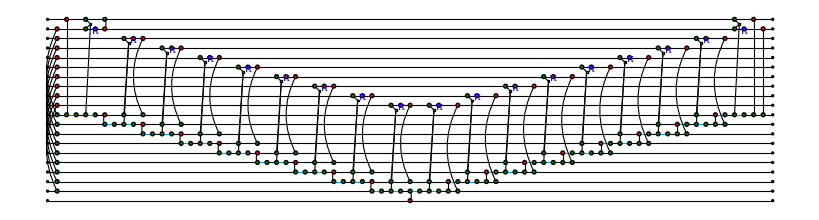

In [49]:
import pyzx as zx
#  The 'd3' backend works better, however, it causes issues when autograding.
#  Feel free to change the backend to 'd3' when testing.
#  When submitting, either re-run with matplotlib or remove the d3 drawings in the notebook
zx.settings.drawing_backend = 'matplotlib'

# The cuccaro adder circuit
cuccaro = generate_adder_circuit(20)
cucc_decomp = qiskit.transpile(cuccaro, basis_gates=['x', 'h', 't', 'tdg', 'cx'])

# Convert the circuit into a ZX diagram
g = zx.Circuit.from_qasm(qasm2.dumps(cuccaro))
print('The ZX diagram of the decomposed cuccaro adder:')
zx.draw(g)

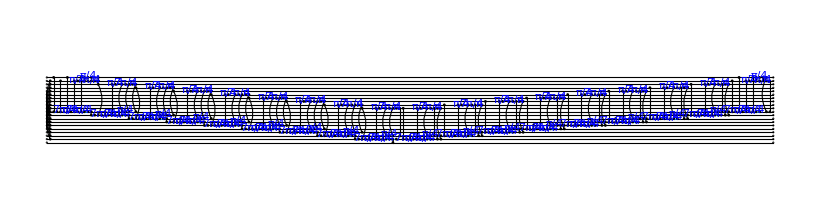

In [50]:
# Simplify the diagram by replacing yellow squares (Hadamards)
g = g.to_basic_gates().to_graph()
zx.draw(g)

## 2.1 Optimizer Routines

Now that we have a ZX diagram of the Cuccaro adder circuit, optimize the ZX diagram using one of the optimization routines listed here: [https://pyzx.readthedocs.io/en/latest/api.html](https://pyzx.readthedocs.io/en/latest/api.html#list-of-simplifications).  Find the one that optimizes this circuit the best.  I.e. the optimizer that results in a circuit with the fewest two-qubit gates.

simpli: 78. 50. 25. 13. 9. 9. 6.  7 iterations


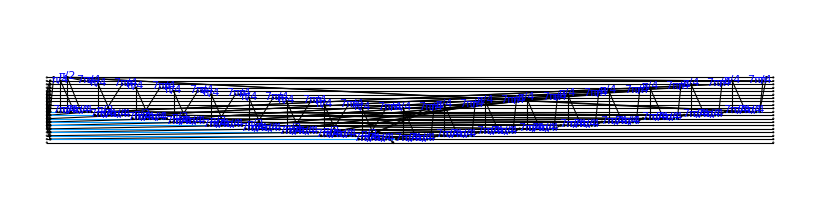

In [66]:
# Reduce the circuit into a the form of a graph
# This will no longer look like a quantum circuit
# Additional work is needed to recover a valid quantum circuit
g_opt = zx.Graph.from_json(g.to_json())  # Convert to zx.Graph before optimizing

# YOUR CODE HERE
zx.simplify.simp(g_opt,"simpli",zx.rules.match_spider_parallel, zx.rules.spider)  # Try different optimizers here
#zx.simplify.bialg_simp(g_opt)  # Try different optimizers here

zx.draw(g_opt)

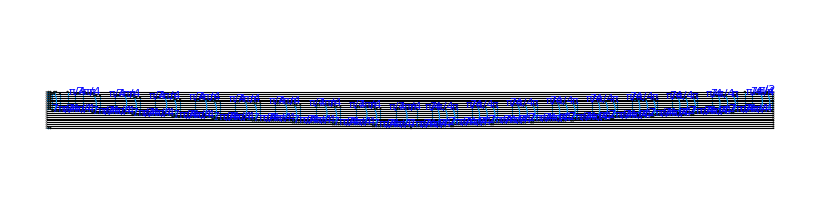

In [67]:
# Convert the graph back into a quantum circuit
# This may not find the smallest possible circuit
c_opt = zx.extract_circuit(g_opt.copy(), quiet=True, optimize_cnots=3)
zx.draw(c_opt)

In [68]:
# Do not delete this cell
# The autograder will test the value stored in `c_opt`.
_optimized = QuantumCircuit.from_qasm_str(c_opt.to_qasm())
assert len(cucc_decomp.qubits) == 20, 'The wrong input circuit was optimized.'
assert len(_optimized.qubits) == 20, 'Wrong number of qubits in the output circuit'
# Hidden tests

In [69]:
# Convert this circuit back into a Qiskit circuit
optimized = QuantumCircuit.from_qasm_str(c_opt.to_qasm())
print(f'Optimized circuit:')
optimized.draw(fold=-1)

Optimized circuit:


┌───┐┌───┐      ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ┌─────────┐  ┌───┐     
 q_0: ┤ H ├┤ H ├────■─┤ H ├───────────────────────────────■──────────────────────────────────────────────────────■───■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [70]:
print(f'Original circuit (for comparison):')
cucc_decomp.draw(fold=-1)

Original circuit (for comparison):


global phase: 7π/4
                                                     ┌───┐                                                 ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ┌───┐           ┌───┐     
  c_in: ─────────────────────────────────────────────┤ X ├───────────────────■─────────────────────■────■──┤ T ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────■────■───┤ T ├───■───────┤ X ├─────
        ┌───┐                                        └─┬─┘                   │             ┌───┐   │  ┌─┴─┐├───┤┌───┐┌───┐┌───┐ ┌───┐ ┌───┐┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐┌───┐└─┬─┘┌───┐
b->s_0: ┤ X ├──────────────────────────────────────────┼─────────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ H ├┤ T ├┤ T ├┤ T ├─┤ T ├─┤ H ├┤ T ├───────────────────────────────────────────────────────────────────────────

## 2.2 Output Circuit

Inspect the above "optimized" quantum circuit.  Does it look similar in structure to the original circuit with some gates removed or changed or is the structure completely different?

In [71]:
answer = (  # 'similar' or 'different'
    # YOUR CODE HERE
            'similar'
)

In [72]:
# Do not delete this cell
# The autograder will test the value stored in `c_opt`.
assert answer in ('similar', 'different'), 'Invalid answer'
# Hidden tests